In [3]:
using MAT
using WebIO
using PyCall
using PyPlot
using Eirene
using Random
using Statistics
using Glob
using DelimitedFiles
using NPZ

rng = MersenneTwister(1337);

┌ Info: Precompiling WebIO [0f1e0344-ec1d-5b48-a673-e5cf874b6c29]
└ @ Base loading.jl:1273


HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-15793390187686293347\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-1115728262939685967\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-15793390187686293347\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

┌ Info: Precompiling PyCall [438e738f-606a-5dbb-bf0a-cddfbfd45ab0]
└ @ Base loading.jl:1273
┌ Info: Precompiling PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1273
┌ Info: Precompiling Eirene [9c0f25c4-2ca1-5870-89f6-52640788da1d]
└ @ Base loading.jl:1273


#### TODO (WZ):
- For each simulation condition (clustered, spanning and individual) at steady state (time-step 150,000) compute changes in Wasserstein distance after randomly removing points (similar to code below). Consider separately Wasserstein distance for $H_0$ and $H_0 + H_1$. Each simulation (in `simulation-data` directory) consists of 200 cells. Change y axis to 4.0 and label with t = blah and delete the old stuff and put legends in top left and extend graph take off the abstract leave 3 bullet move TDA stuff up and leave room for persistence images( make it in python roughly like the other) In middle drop in wasserstein graphs right hand with experimental stuff.

In [4]:
#create function to take create dictionary to data for each condition type
function getdata(condition)
    filelist = glob("Pos_*.dat",string("simulation-data/", condition));
    filetodata = Dict{String, Array{Float64,2}}();
    sz = size(filelist)[1];
    for i in 1:sz
        filenamewext = split(filelist[i], '/')[3];
        filename = split(filenamewext, '.')[1];
        filenum = parse(Int, split(filename, '_')[2]);
        posarray = readdlm(filelist[i], ',', '\n');
        posx = [];
        posy = []
        for j in 1:size(posarray)[2]
            posarray[j] = chop(posarray[j]);
            xsign = 1;
            x_y = split(posarray[j], '-');
            if(x_y[1] == "")
                xsign = -1;
                x_y = deleteat!(x_y,1);
            end
            x_plus_y = [];
            if(size(x_y)[1] == 1)
                x_plus_y = split(posarray[j], '+');
                x_plus_y = map(a->parse(Float64,a),x_plus_y);
                push!(posx, x_plus_y[1]);
                push!(posy, x_plus_y[2]);
            else
                x_y = map(a->parse(Float64,a),x_y);
                x_y[1] *= xsign;
                x_y[2] *= -1;
                push!(posx,x_y[1]);
                push!(posy,x_y[2]);
            end
        end
        positions = transpose(hcat(posx, posy));    
        push!(filetodata, filename => positions)
    end
    return filetodata;
end


getdata (generic function with 1 method)

In [5]:
function wassersteinremoval(condition, filename, maxdimension = 1,num_removals = 98,num_reps = 5, dictdata = nothing, prolif = false)
    conditiondict = Dict{String, Array{Float64,2}}();
    if(dictdata == nothing)
        conditiondict = getdata(condition);
    else
        conditiondict = dictdata;
    end
    pers_diag = eirene(conditiondict[filename], model="pc", maxdim=maxdimension)
    barcodedata = barcode(pers_diag)
    num_particles = size(conditiondict[filename])[2]
    wasserstein_distances = Array{Float64}(undef, num_removals, num_reps);
    if(prolif)
        wasserstein_distances = Array{Float64}(undef, num_particles-2, num_reps);
        for i in 1:(num_particles - 2)
            for j in 1:num_reps
                permutation = randperm(rng, num_particles)
                keep_idx = permutation[1:(num_particles-i)]
                finalpos = conditiondict[filename];
                pos_tmp = finalpos[:,keep_idx]
                pers_diag_tmp = eirene(pos_tmp, model="pc", maxdim=1)
                barcode_tmp = barcode(pers_diag_tmp)
                wasserstein_distances[i, j] = wasserstein_distance(barcode_tmp, barcodedata, q=2, p=2)
            end
        end
    else
        for i in 1:num_removals
            for j in 1:num_reps
                permutation = randperm(rng, num_particles)
                keep_idx = permutation[1:(num_particles-i)]
                finalpos = conditiondict[filename];
                pos_tmp = finalpos[:,keep_idx]
                pers_diag_tmp = eirene(pos_tmp, model="pc", maxdim=1)
                barcode_tmp = barcode(pers_diag_tmp)
                wasserstein_distances[i, j] = wasserstein_distance(barcode_tmp, barcodedata, q=2, p=2)
            end
        end
    end    
    return wasserstein_distances
end

wassersteinremoval (generic function with 6 methods)

In [6]:
function gettotalwasserstein(condition,dimension = 1, num_removal = 98, num_repetition = 5, prolif = false)
    data = getdata(condition);
    wasserstein_all_time = Dict{String, Array{Float64,2}}();
    for (key,value) in data;
        wasserstein_distances = wassersteinremoval(condition,key,dimension,num_removal, num_repetition, data, prolif);
        push!(wasserstein_all_time, key=>wasserstein_distances);
    end
    return wasserstein_all_time
end



gettotalwasserstein (generic function with 5 methods)

In [7]:
function remove0s(strings)
    charfirst = strings[1];
    pos = 1;
    while(charfirst == '0' && pos<length(strings))
        pos += 1;
        charfirst = strings[pos];
    end
    answer = strings[pos:end];
    return answer;
end

remove0s (generic function with 1 method)

In [8]:
function plotwasserstein(condition, dimension = 1, num_removal = 98, num_repetition = 5, wassersteindata = nothing, prolif = false, coloring = "0000FF")
    data = getdata(condition);
    wassersteins = Dict{String, Array{Float64,2}}();
    orderinglist = [];
    coords = [];
    if(wassersteindata == nothing)
         wassersteins = gettotalwasserstein(condition, dimension, num_removal, num_repetition, prolif)
    else
       wassersteins = wassersteindata; 
    end
    figure(figsize=(8,4))
    for (key, value) in wassersteins
        labelnum = remove0s(split(key,"_")[end]);
        push!(orderinglist, (parse(Int64,labelnum),size(data[key])[2], value)); 
    end
    orderinglist =sort(orderinglist);
    i = 1.1;
    for (key,cells,value) in orderinglist
        label=string("t = ",key," (","\$\\Delta\$","t), n = ",cells);

        num_removal = size(value)[1];
        num_repetition = size(value)[2]
        mean_ws_dist = mean(value, dims=2);
        std_ws_dist = std(value, dims=2);
        xs = convert(Array, 1:num_removal)
        lb = collect(Iterators.flatten(convert(Array,mean_ws_dist-std_ws_dist)))
        ub = collect(Iterators.flatten(convert(Array, mean_ws_dist+std_ws_dist)))
        colorf = string("#",uppercase(string(Int(floor(parse(Int,coloring[1:2],base=16)*i))%16^2, base = 16,pad = 2)),uppercase(string(Int(floor(parse(Int,coloring[3:4],base=16)*i))%16^2, base = 16,pad = 2)),uppercase(string(Int(floor(parse(Int,coloring[5:6],base=16)*i))%16^2, base = 16,pad = 2)));
        if(prolif)
            plot(1:98,mean_ws_dist[1:98], label = label, color = colorf)
        else
            plot(1:num_removal, mean_ws_dist,label = label,color=colorf)
        end
        push!(coords, (1:num_removal,mean_ws_dist));
        ax = gca()
        #fill_between(xs, lb, ub, alpha=0.2)
        i*=1.1;
        
    end
    xlabel("Number of removals")
    ylabel("Wasserstein distance")
    ylim(0,5)
    if(prolif)
        title(string(uppercase(condition[1]),split(condition[2:end],"_")[1], " With Proliferation"))
    else
        title(string(uppercase(condition[1]),condition[2:end]))
    end
    legend(bbox_to_anchor=(1.04,1),loc = "upper left");
    return coords;
end

plotwasserstein (generic function with 7 methods)

In [9]:
clusternoprolif = gettotalwasserstein("clustered",1,180,5,false);
spanningnoprolif = gettotalwasserstein("spanning",1,180,5,false);
indivnoprolif = gettotalwasserstein("individual",1,180,5,false);

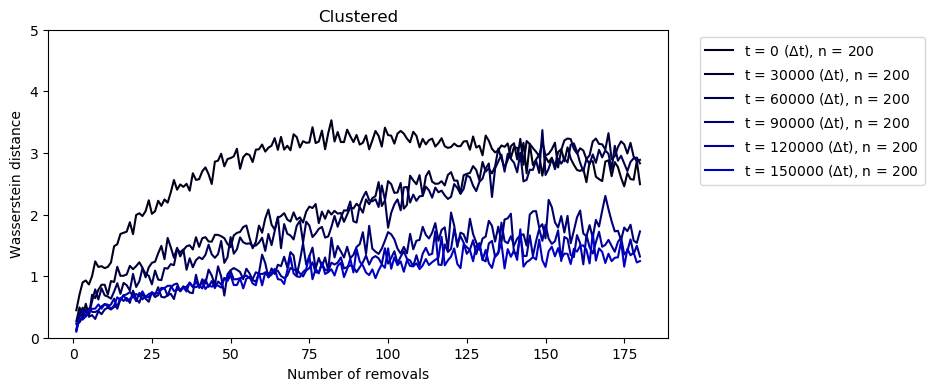

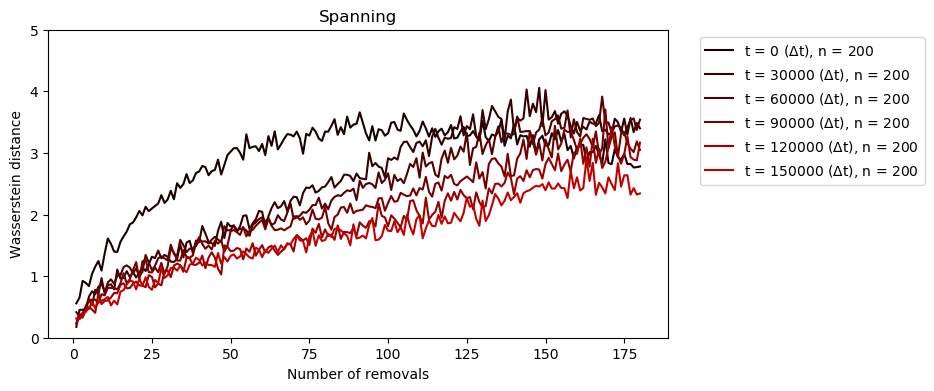

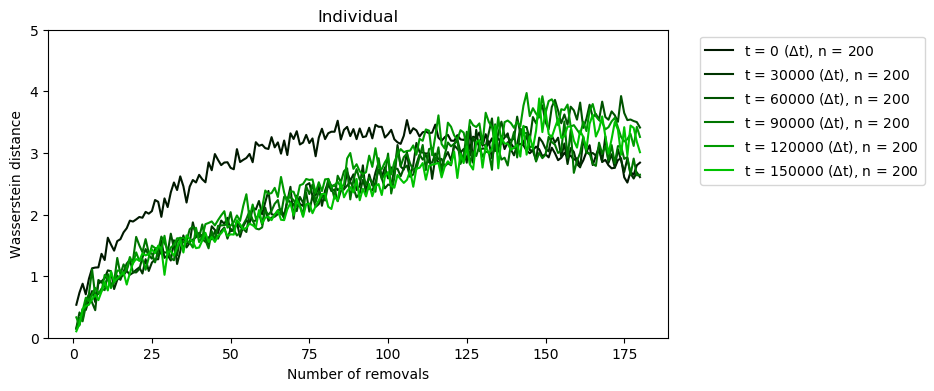

In [10]:
plotwasserstein("clustered",1, 100,3, clusternoprolif,false,"0000FF");
plotwasserstein("spanning",1,100,3, spanningnoprolif,false,"FF0000");
plotwasserstein("individual",1,100,3,indivnoprolif,false,"00FF00");

In [17]:
function plottogether(timestep,conditions, dim = 1, num_removal = 98 ,num_repetition = 5, totalwass= nothing, prolif = false, colors = ["#0000FF","#FF0000","#023424"])
    totalwassallcond = [];
    if(totalwass == nothing)
        for conditionstring in conditions
            data = getdata(conditionstring)
            push!(totalwassallcond, wassersteinremoval(conditionstring, timestep, dim,num_removal,num_repetition, prolif));
        end
    else 
        totalwassallcond = totalwass
    end
    figure(figsize=(8,4))
    i = 1;
    for conditionstring in conditions
        data = getdata(conditionstring);
        if(prolif)
            num_removal = size(data[timestep])[2] - 2;
        end
        lastwass = totalwassallcond[i][timestep];
        mean_ws_dist = mean(lastwass, dims=2);
        std_ws_dist = std(lastwass, dims=2);
        xs = convert(Array, 1:num_removal)
        lb = collect(Iterators.flatten(convert(Array,mean_ws_dist-std_ws_dist)))
        ub = collect(Iterators.flatten(convert(Array, mean_ws_dist+std_ws_dist)))
        if(prolif)
            plot(1:180, mean_ws_dist[1:180],color = colors[i], label=string(string(uppercase(split(conditionstring,"_")[1][1]),split(conditionstring,"_")[1][2:end]),", t = ",remove0s(split(timestep,"_")[end])," (","\$\\Delta\$","t)",", n = ",size(data[timestep])[2]))
        else
            plot(1:num_removal, mean_ws_dist,color = colors[i], label=string(string(uppercase(conditionstring[1]),conditionstring[2:end]),", t = ",remove0s(split(timestep,"_")[end])," (","\$\\Delta\$","t)",", n = ",size(data[timestep])[2])) 
        end
        ax = gca()
        fill_between(xs, lb, ub, alpha=0.2)
        i += 1;
    end
    xlabel("Number of removals")
    ylabel("Wasserstein distance")
    if(prolif)
        xlim(0,180);
        title(string("Timestep ",remove0s(split(timestep,"_")[end]) ," for All Data", " With Proliferation"))
    else
        title(string("Timestep ",remove0s(split(timestep,"_")[end]) ," for All Data"))
    end
    ylim(0,6);
    legend(bbox_to_anchor=(1.04,1),loc = "upper left");
end

plottogether (generic function with 7 methods)

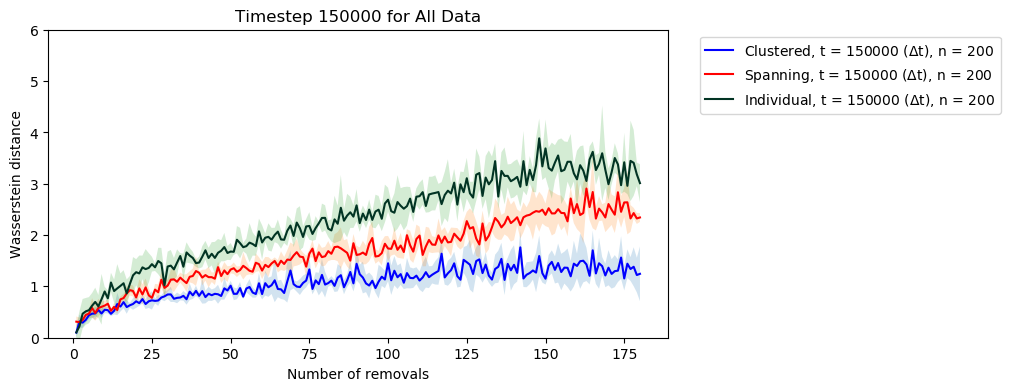

In [12]:
conditions = ["clustered", "spanning","individual"];
lasttimeall = [clusternoprolif,spanningnoprolif,indivnoprolif]
plottogether("Pos_150000", conditions,1, 180,5,lasttimeall,false);

In [13]:
clusterprolif = gettotalwasserstein("clustered_proliferation",1,150,5,true);
spanningprolif = gettotalwasserstein("spanning_proliferation",1,150,5,true);
indivprolif = gettotalwasserstein("individual_proliferation",1,150,5,true);

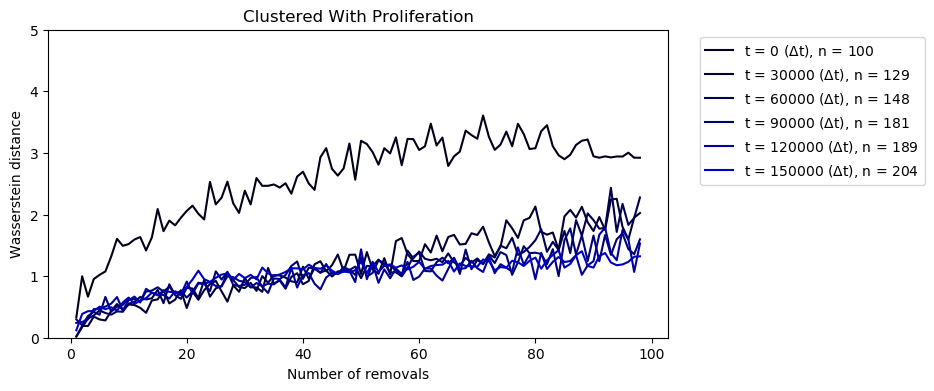

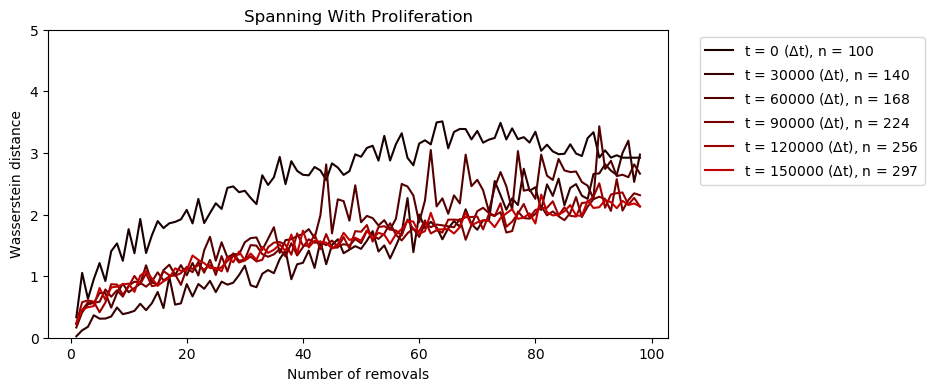

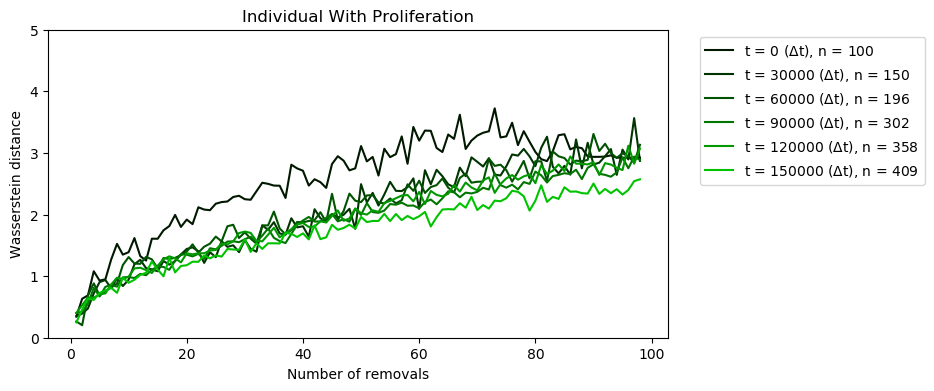

In [14]:
plotwasserstein("clustered_proliferation",1, 150,5, clusterprolif, true,"0000FF");
plotwasserstein("spanning_proliferation",1,150,5, spanningprolif,true,"FF0000");
plotwasserstein("individual_proliferation",1,150,5,indivprolif,true,"00FF00");

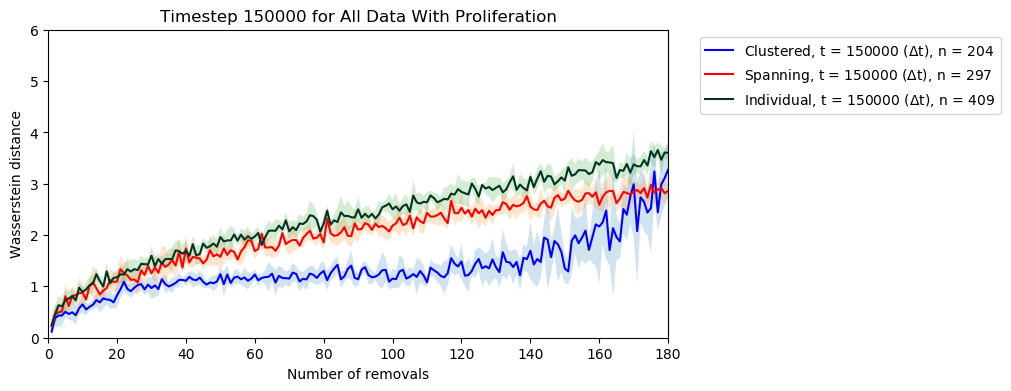

In [18]:
conditions = ["clustered_proliferation", "spanning_proliferation","individual_proliferation"];
lasttimeall = [clusterprolif,spanningprolif,indivprolif]
plottogether("Pos_150000", conditions,1, 150,5,lasttimeall,true);


In [16]:
timestep = "Pos_150000"
#for non prolif store
lastwass = clusternoprolif[timestep];
npzwrite("clustered_removal.npy", lastwass)
lastwass = spanningnoprolif[timestep];
npzwrite("spanning_removal.npy", lastwass)
lastwass = indivnoprolif[timestep];
npzwrite("individual_removal.npy", lastwass)
#for prolif store
lastwass = clusterprolif[timestep];
npzwrite("clustered_proliferation_removal.npy", lastwass)
lastwass = spanningprolif[timestep];
npzwrite("spanning_proliferation_removal.npy", lastwass)
lastwass = indivprolif[timestep];
npzwrite("individual_proliferation_removal.npy", lastwass)